# Loading and exploring the swaptions data

Quick notebook for hackathon participants to:
- load the train Excel file into pandas
- convert it to a PyTorch `Dataset`
- visualize the surface with a heatmap, a few time series, and evolution snapshots / GIF

In [1]:
# useful importations
from pathlib import Path
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# navigating your repository
PROJECT_ROOT = os.path.abspath("/kaggle/input/mila-hackathon")

DATA_PATH = os.path.join(PROJECT_ROOT, "train.xlsx")
PLOTS_DIR = os.path.join(PROJECT_ROOT, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

print(f"Using project root: {PROJECT_ROOT}")
print(f"Train data path: {DATA_PATH}")
print(f"Plots will be saved to: {PLOTS_DIR}")

Using project root: /kaggle/input/mila-hackathon
Train data path: /kaggle/input/mila-hackathon/train.xlsx
Plots will be saved to: /kaggle/input/mila-hackathon/plots


## Load the training data

In [3]:
# Load training data (day-first dates)
df = pd.read_excel(DATA_PATH)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)

# Keep Date as first column
df = df[['Date'] + [c for c in df.columns if c != 'Date']]
feature_cols = [c for c in df.columns if c != 'Date']

df.head()

print(f"Rows: {len(df)}")
print(f"Date range: {df['Date'].min().date()} → {df['Date'].max().date()}")
print(f"Number of surface points: {len(feature_cols)}")

Rows: 494
Date range: 2050-01-01 → 2051-12-23
Number of surface points: 224


## Build a Torch dataset

In [4]:
# Build a simple PyTorch Dataset using the next-day target
import sys
sys.path.append(PROJECT_ROOT)

from data import SwaptionDataset

X = df[feature_cols].copy()
y = df[feature_cols].shift(-1)

# drop last row where target is NaN
mask = ~y.isnull().any(axis=1)
X = X[mask].reset_index(drop=True)
y = y[mask].reset_index(drop=True)

dataset = SwaptionDataset(X, y)
print(f"Dataset size: {len(dataset)} samples")
print(f"Feature dim: {X.shape[1]}, Target dim: {y.shape[1]}")

Dataset size: 493 samples
Feature dim: 224, Target dim: 224


## Visualize the data

In [5]:
# Parsing helpers
def parse_surface_metadata(df):
    tenors, maturities = [], []
    mapping = {}
    for col in df.columns:
        if col == 'Date':
            continue
        parts = col.split(';')
        tenor = float(parts[0].split(':')[1].strip())
        maturity = float(parts[1].split(':')[1].strip())
        tenors.append(tenor)
        maturities.append(maturity)
        mapping[col] = (tenor, maturity)
    return sorted(set(tenors)), sorted(set(maturities)), mapping

def surface_for_date(df, idx, unique_tenors, unique_maturities, mapping):
    row = df.iloc[idx]
    surface = np.full((len(unique_tenors), len(unique_maturities)), np.nan)
    for col, (t, m) in mapping.items():
        t_idx = unique_tenors.index(t)
        m_idx = unique_maturities.index(m)
        surface[t_idx, m_idx] = row[col]
    return surface

unique_tenors, unique_maturities, tm_map = parse_surface_metadata(df)
print(f"Tenors: {len(unique_tenors)} | Maturities: {len(unique_maturities)}")

Tenors: 14 | Maturities: 16


### Some time series using a few key strikes

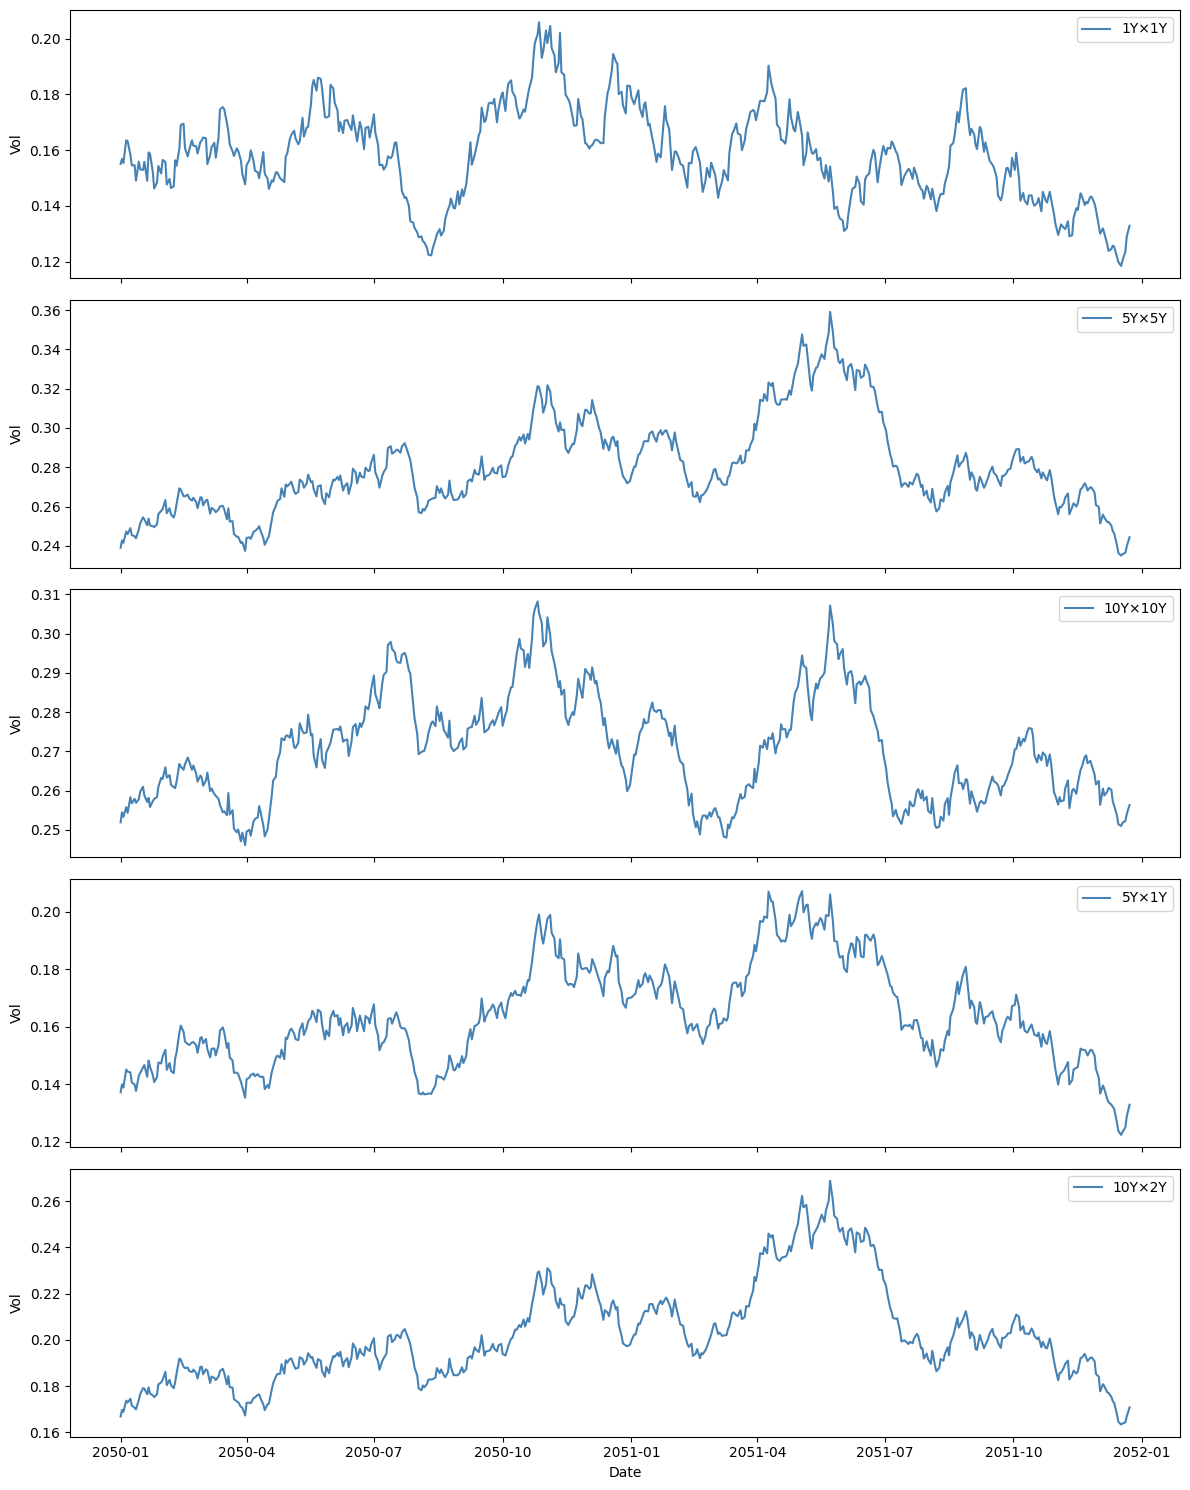

In [6]:
# Time series for a few key strikes
key_strikes = [
    (1, 1, '1Y×1Y'),
    (5, 5, '5Y×5Y'),
    (10, 10, '10Y×10Y'),
    (5, 1, '5Y×1Y'),
    (10, 2, '10Y×2Y'),
]

fig, axes = plt.subplots(len(key_strikes), 1, figsize=(12, 3*len(key_strikes)), sharex=True)
for ax, (tenor, maturity, label) in zip(axes, key_strikes):
    col = None
    for c, (t, m) in tm_map.items():
        if abs(t - tenor) < 0.01 and abs(m - maturity) < 0.01:
            col = c
            break
    if col is None:
        ax.text(0.5, 0.5, f"Missing {label}", ha='center', va='center')
        continue
    ax.plot(df['Date'], df[col], label=label, color='steelblue')
    ax.set_ylabel('Vol')
    ax.legend(loc='upper right')
axes[-1].set_xlabel('Date')
plt.tight_layout()
time_series_path = os.path.join(PLOTS_DIR,'time_series.png')
# fig.savefig(time_series_path, dpi=200)
# print(f"Saved {time_series_path}")
plt.show()

### Heatmap

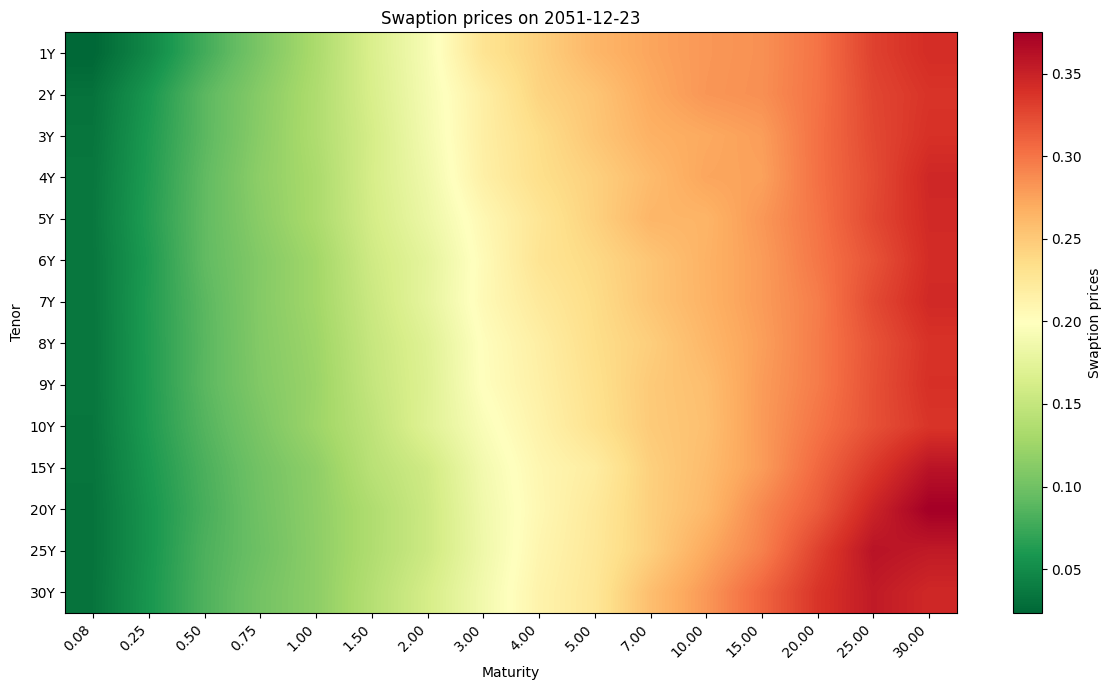

In [7]:
# Heatmap for the latest date
def plot_heatmap(df, index=-1, save=False):
    surface = surface_for_date(df, index, unique_tenors, unique_maturities, tm_map)
    fig, ax = plt.subplots(figsize=(12, 7))
    im = ax.imshow(surface, cmap='RdYlGn_r', aspect='auto', interpolation='bilinear')
    ax.set_title(f"Swaption prices on {df['Date'].iloc[index].date()}")
    ax.set_xlabel('Maturity')
    ax.set_ylabel('Tenor')
    ax.set_xticks(range(len(unique_maturities)))
    ax.set_yticks(range(len(unique_tenors)))
    ax.set_xticklabels([f"{m:.2f}" for m in unique_maturities], rotation=45, ha='right')
    ax.set_yticklabels([f"{t:.0f}Y" for t in unique_tenors])
    plt.colorbar(im, ax=ax, label='Swaption prices')
    plt.tight_layout()
    if save:
        path = os.path.join(PLOTS_DIR,'heatmap_latest.png')
        fig.savefig(path, dpi=200)
        print(f"Saved {path}")
    return fig

plot_heatmap(df, index=-1, save=False)
plt.show()

### Surface evolution

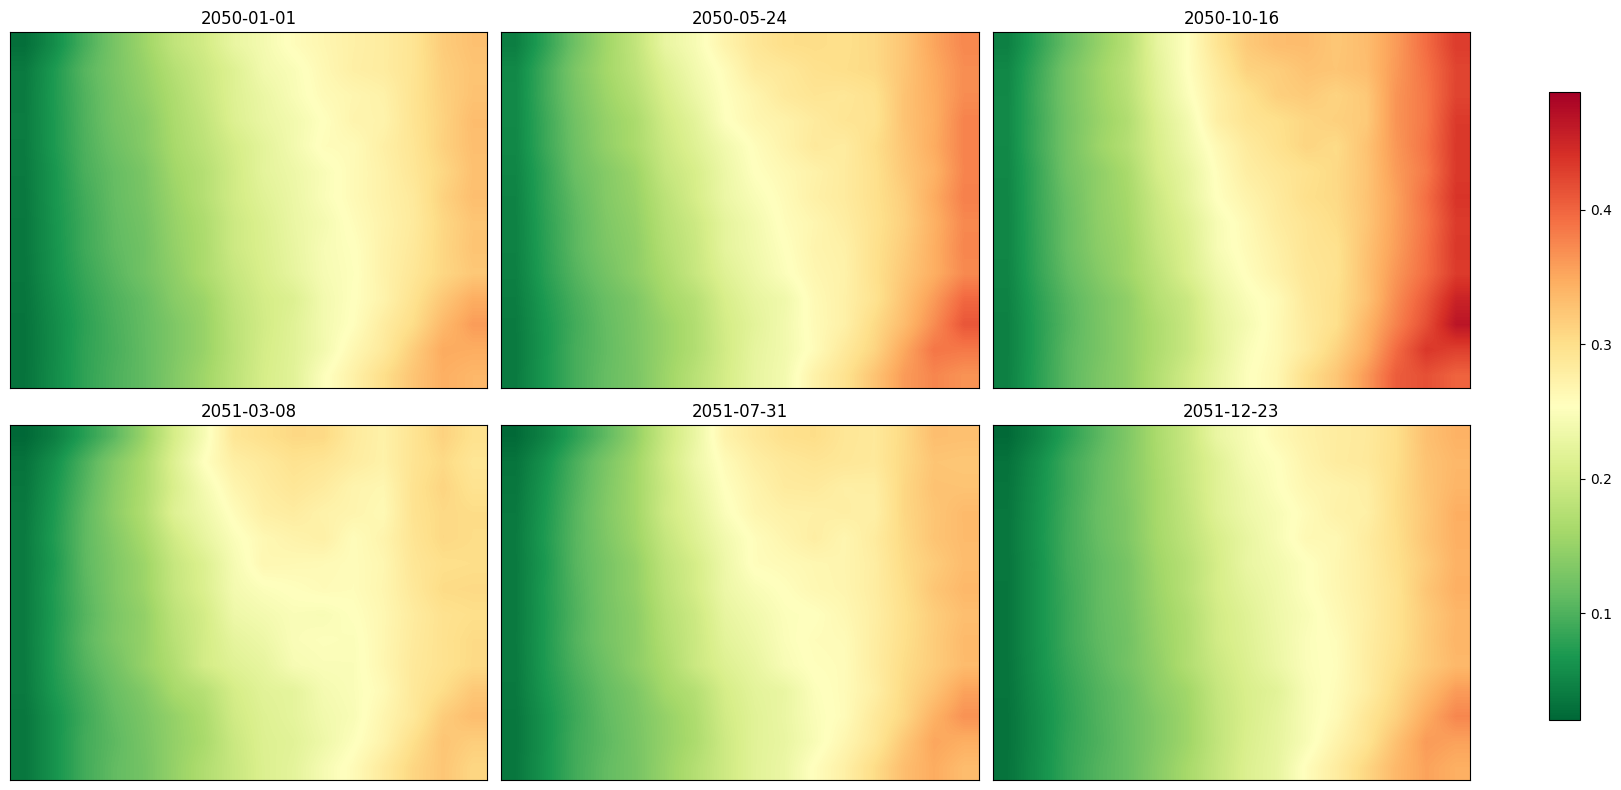

In [8]:
# Surface evolution snapshots
def plot_evolution(df, n_snapshots=6, save=False):
    idxs = np.linspace(0, len(df)-1, n_snapshots, dtype=int)
    vmin = df[feature_cols].values.min()
    vmax = df[feature_cols].values.max()
    n_cols = 3
    n_rows = int(np.ceil(n_snapshots / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten()
    for ax, i in zip(axes, idxs):
        surface = surface_for_date(df, i, unique_tenors, unique_maturities, tm_map)
        im = ax.imshow(surface, cmap='RdYlGn_r', aspect='auto', interpolation='bilinear', vmin=vmin, vmax=vmax)
        ax.set_title(df['Date'].iloc[i].date())
        ax.set_xticks([]); ax.set_yticks([])
    for ax in axes[len(idxs):]:
        ax.axis('off')
    fig.tight_layout()
    fig.colorbar(im, ax=axes, fraction=0.02)
    if save:
        path = os.path.join(PLOTS_DIR, 'evolution_snapshots.png')
        fig.savefig(path, dpi=200)
        print(f"Saved {path}")
    return fig

plot_evolution(df, n_snapshots=6, save=False)
plt.show()

### Evolution GIF

In [9]:
def reshape_to_surface(df, date_idx, unique_tenors, unique_maturities, tenor_maturity_map):
    """
    Reshape flat data into 2D surface for a specific date.

    Returns:
        surface: 2D numpy array (tenor x maturity)
        date: The date for this surface
    """
    date = df['Date'].iloc[date_idx]
    row_data = df.iloc[date_idx]

    # Initialize surface
    surface = np.full((len(unique_tenors), len(unique_maturities)), np.nan)

    # Fill surface
    for col, (tenor, maturity) in tenor_maturity_map.items():
        tenor_idx = unique_tenors.index(tenor)
        maturity_idx = unique_maturities.index(maturity)
        surface[tenor_idx, maturity_idx] = row_data[col]

    return surface, date

def create_evolution_gif(df, unique_tenors, unique_maturities,
                        tenor_maturity_map, save_path='swaption_evolution.gif',
                        fps=5, max_frames=50):
    """
    Create an animated GIF showing surface evolution.

    Args:
        fps: Frames per second
        max_frames: Maximum number of frames (to avoid huge files)
    """
    try:
        from PIL import Image
        import io
    except ImportError:
        print("⚠ PIL/Pillow not installed. Skipping GIF creation.")
        print("  Install with: pip install Pillow")
        return None

    print(f"Creating evolution GIF with {min(len(df), max_frames)} frames...")

    # Select frames
    if len(df) > max_frames:
        frame_indices = np.linspace(0, len(df)-1, max_frames, dtype=int)
    else:
        frame_indices = range(len(df))

    # Global min/max for consistent colors
    vmin = df[[col for col in df.columns if col != 'Date']].min().min()
    vmax = df[[col for col in df.columns if col != 'Date']].max().max()

    frames = []

    for frame_num, idx in enumerate(frame_indices):
        if frame_num % 10 == 0:
            print(f"  Frame {frame_num+1}/{len(frame_indices)}...")

        # Create frame
        fig, ax = plt.subplots(figsize=(12, 8))

        surface, date = reshape_to_surface(df, idx, unique_tenors,
                                          unique_maturities, tenor_maturity_map)

        im = ax.imshow(surface, cmap='RdYlGn_r', aspect='auto',
                      interpolation='bilinear', vmin=vmin, vmax=vmax)

        # Format labels (simplified for animation)
        maturity_labels = [f'{int(m)}Y' if m >= 1 else f'{int(m*12)}M'
                          for m in unique_maturities[::2]]
        tenor_labels = [f'{int(t)}Y' for t in unique_tenors[::2]]

        ax.set_xticks(range(0, len(unique_maturities), 2))
        ax.set_yticks(range(0, len(unique_tenors), 2))
        ax.set_xticklabels(maturity_labels, rotation=45, ha='right')
        ax.set_yticklabels(tenor_labels)

        ax.set_xlabel('Maturity', fontsize=12, fontweight='bold')
        ax.set_ylabel('Tenor', fontsize=12, fontweight='bold')
        ax.set_title(f'Swaption Prices Surface\n{date.strftime("%Y-%m-%d")}',
                    fontsize=14, fontweight='bold')

        plt.colorbar(im, ax=ax, label='Swaption prices')
        plt.tight_layout()

        # Save frame to buffer
        buf = io.BytesIO()
        # plt.savefig(buf, format='png', dpi=100)
        buf.seek(0)
        frames.append(Image.open(buf))
        plt.close(fig)

    # Save as GIF
    # frames[0].save(save_path, save_all=True, append_images=frames[1:],
    #                duration=int(1000/fps), loop=0, optimize=False)

    print(f"✓ Created GIF: {save_path}")
    return save_path



Creating evolution GIF with 50 frames...
  Frame 1/50...


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7cc7cd8ab920>

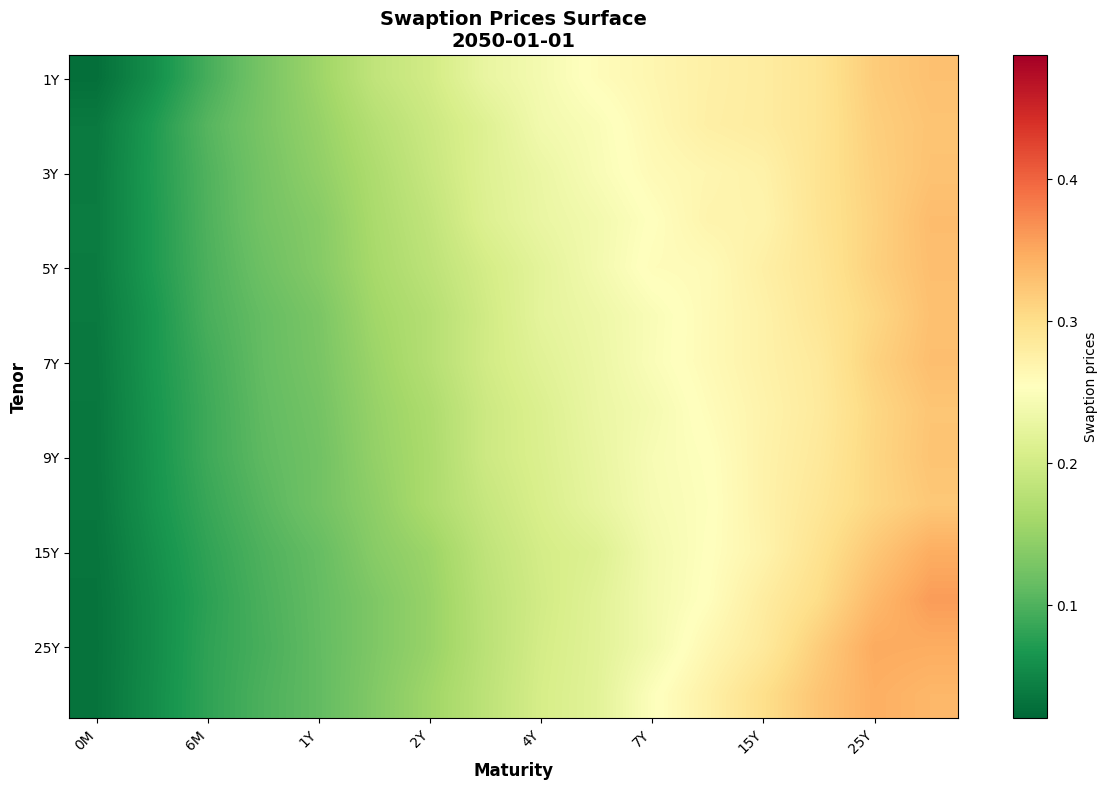

In [10]:
gif_output_path = os.path.join(PLOTS_DIR, 'swaption_surface_evolution.gif')
created_gif_path = create_evolution_gif(df, unique_tenors, unique_maturities, tm_map, save_path=gif_output_path)

from IPython.display import Image
display(Image(filename=created_gif_path))

# Classical Transformer

In [11]:
import torch
import torch.nn as nn
import numpy as np
import math

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, output_dim=1, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        
        self.model_type = 'Transformer'
        self.d_model = d_model

        # 1. Embedding Layer: Projects input features to d_model size
        self.embedding = nn.Linear(input_dim, d_model)
        
        # 2. Positional Encoding: Injects information about the sequence order
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        # 3. Transformer Encoder: The core attention mechanism
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=512, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        
        # 4. Output Layer: Projects back to target dimension (e.g., 1 for price)
        self.decoder = nn.Linear(d_model, output_dim)

    def forward(self, src):
        # src shape: [batch_size, seq_len, input_dim]
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        
        # Transformer output shape: [batch_size, seq_len, d_model]
        output = self.transformer_encoder(src)
        
        # We only care about the output of the last time step for prediction
        # pooling shape: [batch_size, d_model]
        last_step_output = output[:, -1, :]
        
        prediction = self.decoder(last_step_output)
        return prediction

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # Shape: [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [12]:
# 1. Melt the dataframe to turn columns into rows
# This stacks all the "Tenor: X; Maturity: Y" columns into one column called 'variable'
df_melted = df.melt(id_vars=['Date'], var_name='Surface_Key', value_name='Price')

# 2. Map the Tenor and Maturity using your existing tm_map
# tm_map is likely { 'Tenor:1; Maturity:1': (1.0, 1.0), ... }
df_melted['Tenor'] = df_melted['Surface_Key'].map(lambda x: tm_map[x][0])
df_melted['Maturity'] = df_melted['Surface_Key'].map(lambda x: tm_map[x][1])

# 3. Organize the DataFrame
# We drop 'Surface_Key' because we now have numeric Tenor/Maturity columns
df_model = df_melted[['Date', 'Tenor', 'Maturity', 'Price']]

# 4. Sort by Date (Crucial for Time Series training)
df_model = df_model.sort_values(by=['Date', 'Tenor', 'Maturity']).reset_index(drop=True)

# 5. Handle Missing Values (The "Purple Rows")
# For TRAINING a baseline, you usually want to drop rows where the target (Price) is NaN
# You will predict these later.
df_train_ready = df_model.dropna(subset=['Price'])

print("Shape of Long Format Data:", df_model.shape)
print(df_model.head())

Shape of Long Format Data: (110656, 4)
        Date  Tenor  Maturity     Price
0 2050-01-01    1.0  0.083333  0.028565
1 2050-01-01    1.0  0.250000  0.057880
2 2050-01-01    1.0  0.500000  0.095031
3 2050-01-01    1.0  0.750000  0.127411
4 2050-01-01    1.0  1.000000  0.155058


In [13]:
def create_sequences(data, seq_length, target_col_idx):
    """
    Creates sequences for training/testing.
    data: Normalized numpy array of shape (num_samples, num_features)
    seq_length: Number of past time steps to look at
    target_col_idx: Index of the column we want to predict
    """
    xs = []
    ys = []
    
    for i in range(len(data) - seq_length):
        x = data[i : i+seq_length]
        y = data[i+seq_length, target_col_idx] # Predict the NEXT step
        xs.append(x)
        ys.append(y)
        
    return np.array(xs), np.array(ys)

# --- Usage Example ---
# Assuming 'df_model' is your preprocessed dataframe from the previous step
# and all columns are numeric (One-Hot Encoded or similar)

from sklearn.preprocessing import MinMaxScaler

# Set 'Date' as the index so it is excluded from .values, but preserved for reference
df_numeric = df_model.set_index('Date') 

scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(df_numeric.values)
SEQ_LENGTH = 10  # Look back 10 days
target_idx = 0   # Assuming the first column is 'Price'

X, y = create_sequences(data_normalized, SEQ_LENGTH, target_idx)

# Convert to PyTorch tensors
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float().unsqueeze(1) # Shape [batch, 1]

print(f"Input Shape: {X_tensor.shape}") # Should be [samples, 10, num_features]

Input Shape: torch.Size([110646, 10, 3])


In [14]:
import torch
import gc

# 1. Delete old variables that might be holding GPU memory
try:
    del model
    del optimizer
    del X_tensor
    del y_tensor
    del batch_X
    del batch_y
except NameError:
    pass # Variables might not exist yet

# 2. Force Python to garbage collect
gc.collect()

# 3. Clear PyTorch's cache
torch.cuda.empty_cache()

print(f"Memory Cleared. Free: {torch.cuda.mem_get_info()[0] / 1e9:.2f} GB")

Memory Cleared. Free: 16.79 GB


Using device: cuda
Train: 338, Val: 73, Test: 73
Starting training (Max Epochs: 100, Patience: 5)...
Epoch 1: Train Loss 0.153614 | Val Loss 0.062260
Epoch 2: Train Loss 0.059260 | Val Loss 0.045577
Epoch 3: Train Loss 0.045255 | Val Loss 0.038164
Epoch 4: Train Loss 0.037701 | Val Loss 0.031642
Epoch 5: Train Loss 0.029178 | Val Loss 0.031326
Epoch 6: Train Loss 0.021665 | Val Loss 0.011127
Epoch 7: Train Loss 0.014913 | Val Loss 0.010529
Epoch 8: Train Loss 0.012374 | Val Loss 0.017753
Epoch 9: Train Loss 0.010807 | Val Loss 0.007726
Epoch 10: Train Loss 0.008673 | Val Loss 0.008017
Epoch 11: Train Loss 0.008013 | Val Loss 0.007702
Epoch 12: Train Loss 0.007484 | Val Loss 0.009035
Epoch 13: Train Loss 0.006500 | Val Loss 0.005216
Epoch 14: Train Loss 0.005898 | Val Loss 0.008081
Epoch 15: Train Loss 0.005534 | Val Loss 0.004060
Epoch 16: Train Loss 0.005994 | Val Loss 0.009985
Epoch 17: Train Loss 0.005649 | Val Loss 0.004609
Epoch 18: Train Loss 0.005001 | Val Loss 0.003732
Epoch 19

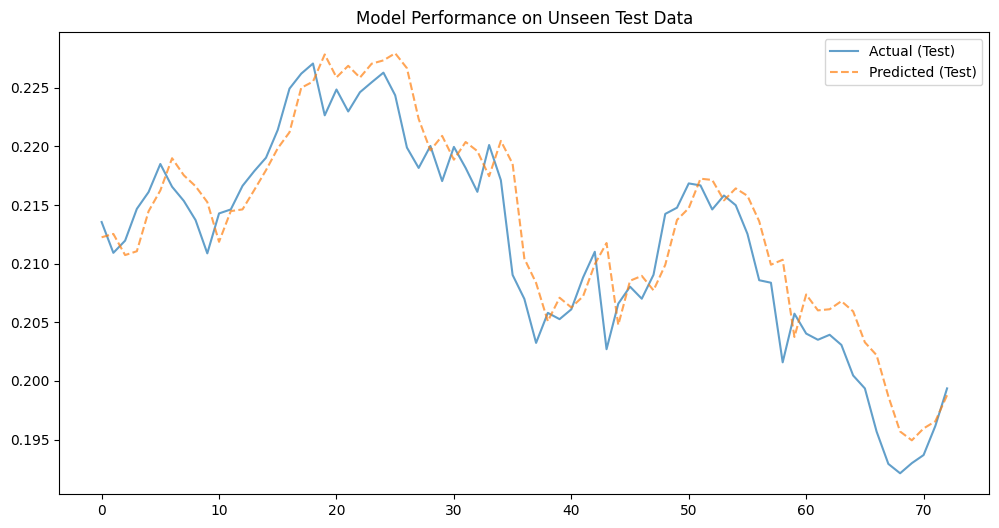


🚀 Retraining on 100% of data for 25 epochs...
Full-Train Epoch 5/25 | Loss: 0.020682
Full-Train Epoch 10/25 | Loss: 0.006022
Full-Train Epoch 15/25 | Loss: 0.004174
Full-Train Epoch 20/25 | Loss: 0.003767
Full-Train Epoch 25/25 | Loss: 0.003783
✅ Final model trained on all data and saved!


In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import copy

# ==========================================
# 1. CONFIGURATION & DATA PREPARATION
# ==========================================
SEQ_LENGTH = 10
BATCH_SIZE = 32
MAX_EPOCHS = 100   # Set this high, early stopping will cut it short
PATIENCE = 5       # Stop if validation loss doesn't improve for 5 epochs
LEARNING_RATE = 0.001
SPLIT_RATIO = [0.7, 0.15, 0.15] # 70% Train, 15% Val, 15% Test

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load & Process Data
file_path = '/kaggle/input/mila-hackathon/train.xlsx' 
df = pd.read_excel(file_path)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').set_index('Date')

# Interpolate & Scale
df_clean = df.interpolate(method='linear', limit_direction='both').fillna(0)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_clean.values)

# Create Sequences
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        x = data[i : i+seq_len]
        y = data[i+seq_len]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X_all, y_all = create_sequences(data_scaled, SEQ_LENGTH)

# 3-Way Split (Train / Val / Test)
n = len(X_all)
train_end = int(n * SPLIT_RATIO[0])
val_end = int(n * (SPLIT_RATIO[0] + SPLIT_RATIO[1]))

X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val, y_val = X_all[train_end:val_end], y_all[train_end:val_end]
X_test, y_test = X_all[val_end:], y_all[val_end:]

# Convert to Tensors
def to_tensor(x): return torch.from_numpy(x).float().to(device)

X_train_t, y_train_t = to_tensor(X_train), to_tensor(y_train)
X_val_t, y_val_t = to_tensor(X_val), to_tensor(y_val)
X_test_t, y_test_t = to_tensor(X_test), to_tensor(y_test)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# ==========================================
# 2. MODEL DEFINITION
# ==========================================
class SurfaceTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 500, d_model))
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=256, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, input_dim)

    def forward(self, src):
        x = self.embedding(src) + self.pos_encoder[:, :src.size(1), :]
        x = self.transformer(x)
        return self.decoder(x[:, -1, :])

# Initialize
model = SurfaceTransformer(input_dim=X_train.shape[2], d_model=128, nhead=4, num_layers=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

# Stability fix
torch.backends.cuda.enable_flash_sdp(False)
torch.backends.cuda.enable_mem_efficient_sdp(False)

# ==========================================
# 3. TRAINING WITH EARLY STOPPING
# ==========================================
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)
# Validation loader (no shuffle)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=BATCH_SIZE, shuffle=False)

best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
patience_counter = 0

print(f"Starting training (Max Epochs: {MAX_EPOCHS}, Patience: {PATIENCE})...")

for epoch in range(MAX_EPOCHS):
    # --- Training Phase ---
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        pred = model(batch_X)
        loss = criterion(pred, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    
    # --- Validation Phase ---
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            pred = model(batch_X)
            loss = criterion(pred, batch_y)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.6f} | Val Loss {avg_val_loss:.6f}")
    
    # --- Early Stopping Check ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        patience_counter = 0 # Reset counter
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\n⏹️ Early stopping triggered! No improvement for {PATIENCE} epochs.")
            break

# Load best weights
model.load_state_dict(best_model_wts)
print(f"Training complete. Best Val Loss: {best_val_loss:.6f}")

# ==========================================
# 4. FINAL EVALUATION (TEST SET)
# ==========================================
model.eval()
with torch.no_grad():
    test_preds_scaled = model(X_test_t).cpu().numpy()
    test_actuals_scaled = y_test_t.cpu().numpy()

# Inverse Transform
test_preds_real = scaler.inverse_transform(test_preds_scaled)
test_actuals_real = scaler.inverse_transform(test_actuals_scaled)

# Metrics
rmse = np.sqrt(mean_squared_error(test_actuals_real, test_preds_real))
print(f"\n✅ Final Test RMSE: {rmse:.5f}")

# Plot
avg_actual = np.mean(test_actuals_real, axis=1)
avg_pred = np.mean(test_preds_real, axis=1)

plt.figure(figsize=(12, 6))
plt.plot(avg_actual, label='Actual (Test)', alpha=0.7)
plt.plot(avg_pred, label='Predicted (Test)', alpha=0.7, linestyle='--')
plt.title('Model Performance on Unseen Test Data')
plt.legend()
plt.show()

# ==========================================
# 5. PRODUCTION RETRAINING (FULL DATA)
# ==========================================

# 1. Determine optimal epochs from the Early Stopping run
# (If early stopping triggered at epoch 25 with patience 5, the best was epoch 20)
optimal_epochs = max(1, epoch - PATIENCE + 1)

print(f"\n🚀 Retraining on 100% of data for {optimal_epochs} epochs...")

# 2. Combine all data
# Create one big TensorDataset with everything
X_full_tensor = torch.cat([X_train_t, X_val_t, X_test_t], dim=0)
y_full_tensor = torch.cat([y_train_t, y_val_t, y_test_t], dim=0)

full_loader = DataLoader(TensorDataset(X_full_tensor, y_full_tensor), 
                         batch_size=BATCH_SIZE, shuffle=True)

# 3. Re-Initialize a fresh model
final_model = SurfaceTransformer(input_dim=X_train.shape[2], 
                                 d_model=128, nhead=4, num_layers=2).to(device)
final_optimizer = optim.Adam(final_model.parameters(), lr=LEARNING_RATE)

# 4. Train on Full Data
final_model.train()
for ep in range(optimal_epochs):
    total_loss = 0
    for batch_X, batch_y in full_loader:
        final_optimizer.zero_grad()
        pred = final_model(batch_X)
        loss = criterion(pred, batch_y)
        loss.backward()
        final_optimizer.step()
        total_loss += loss.item()
        
    # Optional: Print progress
    if (ep+1) % 5 == 0 or ep == optimal_epochs-1:
        print(f"Full-Train Epoch {ep+1}/{optimal_epochs} | Loss: {total_loss/len(full_loader):.6f}")

# 5. Save the Final "Production" Model
torch.save(final_model.state_dict(), 'production_model_full_data.pth')
print("✅ Final model trained on all data and saved!")

# QML

In [16]:
!pip install qiskit qiskit-machine-learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 68.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 92.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 33.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not i

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Qiskit Imports
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# ==========================================
# 1. CONFIGURATION
# ==========================================
SEQ_LENGTH = 10
BATCH_SIZE = 16   # Smaller batch size for Quantum simulation speed
EPOCHS = 50        # Quantum training is SLOW; start small
LEARNING_RATE = 0.001
N_QUBITS = 4      # Number of qubits for the quantum layer

device = torch.device("cpu") # Qiskit simulators run best on CPU generally
print(f"Using device: {device} (Quantum simulation is CPU-bound)")

# ==========================================
# 2. DATA PREPARATION (Wide Format)
# ==========================================
print("Loading and processing data...")
file_path = '/kaggle/input/mila-hackathon/train.xlsx' 
df = pd.read_excel(file_path)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').set_index('Date')

# Interpolate & Scale
df_clean = df.interpolate(method='linear', limit_direction='both').fillna(0)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_clean.values)

def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        xs.append(data[i : i+seq_len])
        ys.append(data[i+seq_len])
    return np.array(xs), np.array(ys)

X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Convert to Tensors
X_tensor = torch.from_numpy(X).float().to(device)
y_tensor = torch.from_numpy(y).float().to(device)

# Loaders
train_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=BATCH_SIZE, shuffle=True)

print(f"Data ready. Input shape: {X_tensor.shape}")

# ==========================================
# 3. QUANTUM LAYER DEFINITION
# ==========================================
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.quantum_info import SparsePauliOp

def create_qnn(n_qubits):
    """
    Constructs a Quantum Neural Network using Qiskit.
    """
    # 1. Define Circuit
    feature_map = ZZFeatureMap(feature_dimension=n_qubits, reps=1)
    ansatz = RealAmplitudes(num_qubits=n_qubits, reps=1)
    
    qc = QuantumCircuit(n_qubits)
    qc.append(feature_map, range(n_qubits))
    qc.append(ansatz, range(n_qubits))
    
    # 2. Define Observables (The Fix)
    # We create a list of observables to measure Z on each qubit individually.
    # We assume standard Qiskit little-endian ordering (qubit 0 is right-most).
    observables = []
    for i in range(n_qubits):
        # Construct string like "IIIZ", "IIZI", etc.
        pauli_str_list = ["I"] * n_qubits
        pauli_str_list[n_qubits - 1 - i] = "Z" # Set Z on the i-th qubit
        pauli_str = "".join(pauli_str_list)
        observables.append(SparsePauliOp(pauli_str))
    
    # 3. Create QNN Primitive
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        observables=observables
    )
    return qnn
# ==========================================
# 4. HYBRID MODEL ARCHITECTURE
# ==========================================
class HybridQuantumTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, n_qubits, dropout=0.1):
        super().__init__()
        
        # --- Classical Encoder ---
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 500, d_model))
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=128, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layers, num_layers)
        
        # --- Quantum Bridge ---
        self.n_qubits = n_qubits
        self.pre_quantum = nn.Linear(d_model, n_qubits) # Compress 128 -> 4
        
        # Qiskit Layer
        self.qnn = create_qnn(n_qubits)
        self.quantum_layer = TorchConnector(self.qnn)
        
        # --- Classical Decoder ---
        self.post_quantum = nn.Linear(n_qubits, input_dim) # Expand 4 -> 224

    def forward(self, src):
        # 1. Classical Transformer
        x = self.embedding(src) + self.pos_encoder[:, :src.size(1), :]
        x = self.transformer(x)
        
        # Take last time step
        x_last = x[:, -1, :]
        
        # 2. Quantum Bottleneck
        x_reduced = self.pre_quantum(x_last) # Down to 4 dims
        x_quantum = self.quantum_layer(x_reduced) # Pass through Qiskit circuit
        
        # 3. Final Prediction
        out = self.post_quantum(x_quantum)
        return out

# Initialize Hybrid Model
num_features = X_tensor.shape[2]
d_model = 64 # Smaller d_model to save resources
model = HybridQuantumTransformer(num_features, d_model, 4, 1, N_QUBITS).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

print("Quantum Model Initialized.")

# ==========================================
# 5. TRAINING LOOP (Expect Slowness!)
# ==========================================
print(f"Starting Hybrid Training for {EPOCHS} epochs...")
print("(Note: Each epoch may take several minutes due to quantum simulation)")

model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for i, (batch_X, batch_y) in enumerate(train_loader):
        optimizer.zero_grad()
        pred = model(batch_X)
        loss = criterion(pred, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        # Print progress every 50 batches
        if i % 50 == 0:
            print(f"  Epoch {epoch+1} | Batch {i}/{len(train_loader)} | Loss: {loss.item():.4f}")
            
    print(f"Epoch {epoch+1} Complete. Avg Loss: {total_loss/len(train_loader):.6f}")

# ==========================================
# 6. PREDICT & SUBMIT
# ==========================================
print("\nGenerating Forecast...")

# Load template for length
try:
    df_template = pd.read_excel('/kaggle/input/mila-hackathon/template_track2_results.xlsx')
    future_days = len(df_template)
except:
    future_days = 14

# Autoregressive Loop
current_seq = torch.tensor(data_scaled[-SEQ_LENGTH:]).float().unsqueeze(0).to(device)
predictions_scaled = []

model.eval()
with torch.no_grad():
    for _ in range(future_days):
        next_pred = model(current_seq)
        predictions_scaled.append(next_pred.cpu().numpy().flatten())
        
        next_input = next_pred.unsqueeze(1)
        current_seq = torch.cat((current_seq[:, 1:, :], next_input), dim=1)

# Save
predictions_real = scaler.inverse_transform(np.array(predictions_scaled))
pred_df = pd.DataFrame(predictions_real, columns=df.columns)

if 'df_template' in locals():
    pred_df.insert(0, 'Date', df_template['Date'].values)
else:
    last_date = df.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)
    pred_df.insert(0, 'Date', future_dates)

pred_df.to_excel('track2_quantum_submission.xlsx', index=False)
print("✅ Quantum Submission Created: 'track2_quantum_submission.xlsx'")

Using device: cpu (Quantum simulation is CPU-bound)
Loading and processing data...
Data ready. Input shape: torch.Size([484, 10, 224])
Quantum Model Initialized.
Starting Hybrid Training for 50 epochs...
(Note: Each epoch may take several minutes due to quantum simulation)
  Epoch 1 | Batch 0/31 | Loss: 0.3508
Epoch 1 Complete. Avg Loss: 0.296963
  Epoch 2 | Batch 0/31 | Loss: 0.2656
Epoch 2 Complete. Avg Loss: 0.268178
  Epoch 3 | Batch 0/31 | Loss: 0.2384
Epoch 3 Complete. Avg Loss: 0.244017
  Epoch 4 | Batch 0/31 | Loss: 0.2493
Epoch 4 Complete. Avg Loss: 0.223353
  Epoch 5 | Batch 0/31 | Loss: 0.1858
Epoch 5 Complete. Avg Loss: 0.200628
  Epoch 6 | Batch 0/31 | Loss: 0.2827
Epoch 6 Complete. Avg Loss: 0.185166
  Epoch 7 | Batch 0/31 | Loss: 0.1633
Epoch 7 Complete. Avg Loss: 0.169305
  Epoch 8 | Batch 0/31 | Loss: 0.1507
Epoch 8 Complete. Avg Loss: 0.153198
  Epoch 9 | Batch 0/31 | Loss: 0.1674
Epoch 9 Complete. Avg Loss: 0.142621
  Epoch 10 | Batch 0/31 | Loss: 0.1131
Epoch 10 Com

In [ ]:
print(model)